Front-to-back wheelbase is .337 m.

In [1]:
import numpy as np, matplotlib.pyplot as plt, scipy.ndimage

In [2]:
raw = plt.imread('IMG_20190307_192522.jpg')

Data collected thanks to [Ankit Rohatgi's WebPlotDigitizer](https://apps.automeris.io/wpd/).

In [3]:
cropped = np.fliplr(np.rot90(raw[:700], k=1, axes=(0, 1)))
cropped = scipy.ndimage.rotate(cropped, 1.25)

labeled = np.array([
    [float(x) for x in r.split(',')]
    for r in 
    '''
    0.5164939360529218, 0.6186077979352513
    0.4861283953092113, 0.686685777287762
    0.36748391299989985, 0.7709225218001406
    0.3125391400220508, 0.7743883933046007
    0.2796326551067456, 0.8280520196451842
    0.23480134308910494, 0.8843552169990982
    0.12946537035180927, 0.8695047609501856
    0.11545244061341098, 0.9011107547358927
    -0.015770973238448338, 0.925325949684274
    -0.03509221208780189, 0.9064128495539743
    -0.13320787811967516, 0.896244762954796
    -0.15751037385987765, 0.8581431291971535
    -0.27716117069259294, 0.8459781497444121
    -0.32287300791821183, 0.8179298386288464
    -0.40451027362934755, 0.7833399819585045
    -0.38337766863786715, 0.7467761852260197
    -0.5086135110754735, 0.6575816377668636
    -0.5690930139320438, 0.5888380274631652
    -0.12238999699308406, 0.32956329557983355
    0.13100000000000012, 0.3295173899969931
    0.14596892853563204, -0.06850696602185047
    -0.11461621729978955, -0.07073338678961649
    '''.split('\n')
    if len(r.strip()) > 0
])

# Points 20 and 21 
yoffset = labeled[20:22][:, 1].mean()
labeled[:, 1] -= yoffset

#xoffset = np.diff(labeled[18:20][:, 0])
xoffset = .0#25

labeled[:, 0] -= xoffset

pairs = (
    [0,  3,  'r',  1  ],
    [1,  4,  'g',  .75],
    [2,  6,  'r',  .5 ],
    [5,  8,  'g',  .25],
    [7,  10, 'w',  0  ],
    [9,  12, 'r', -.25],
    [11, 15, 'g', -.5 ],
    [13, 16, 'w', -.75],
    [14, 17, 'r', -1  ]
)

def get_prediction(reciprocal_diameter, driving_distance):
    
    if reciprocal_diameter == 0:
        xpred = 0
        ypred = driving_distance
        
    else:
        diameter = np.abs(1. / reciprocal_diameter)
        radius = diameter / 2.
        signed_radius = (1. / reciprocal_diameter) / 2.
    
        circumfrence = np.pi * diameter
        angle_fraction = driving_distance / circumfrence
        theta = angle_fraction * np.pi * 2
        
        if signed_radius > 0:
            xpred = radius * np.cos(np.pi - theta)
            ypred = radius * np.sin(np.pi - theta)
        else:
            xpred = radius * np.cos(theta)
            ypred = radius * np.sin(theta)

        xpred += signed_radius
        
    return xpred, ypred

In [4]:
def objective(driving_distance_turn_rate):
    driving_distance, turn_rate = driving_distance_turn_rate
    true_positions = np.array([
        labeled[[i,j]].mean(0)
        for (i,j,c,w) in pairs
    ])
    
    predicted_positions = np.array([
        get_prediction(w / turn_rate, driving_distance)
        for (i,j,c,w) in pairs
    ])
    
    deviations = true_positions - predicted_positions
    
    distances = np.linalg.norm(deviations, axis=1)
    
    return np.mean(distances)

from scipy.optimize import minimize
solution = minimize(objective, [1, 1.5])
print(solution)
best_driving_distance, best_turn_rate = solution.x

      fun: 0.0291427372234451
 hess_inv: array([[0.0697002 , 0.1546857 ],
       [0.1546857 , 0.40609021]])
      jac: array([1.23633072e-07, 7.45058060e-09])
  message: 'Optimization terminated successfully.'
     nfev: 60
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([0.94926852, 1.65849761])


/home/tsbertalan/.virtualenvs/tfgpu/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


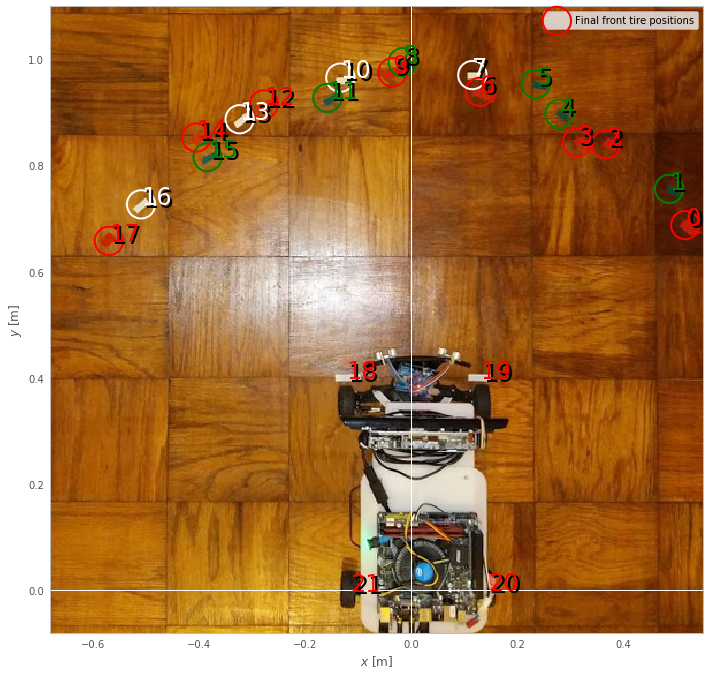

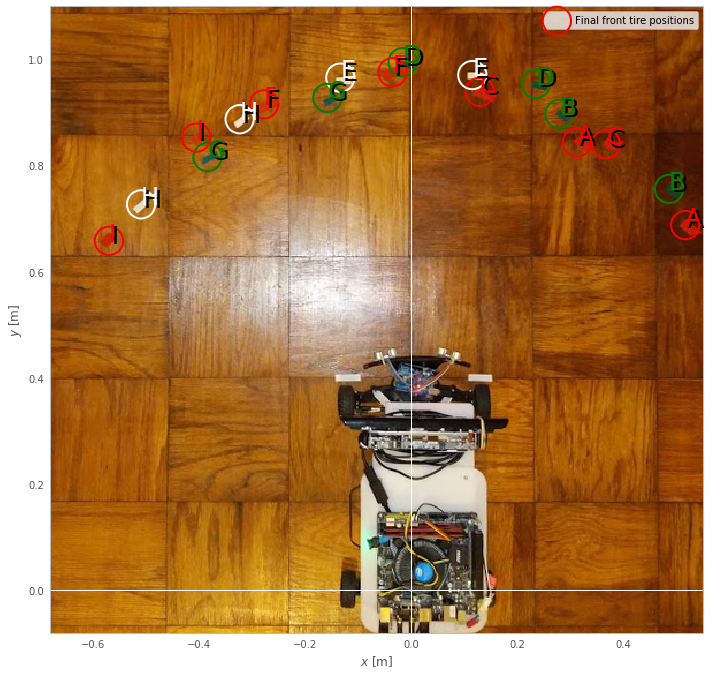

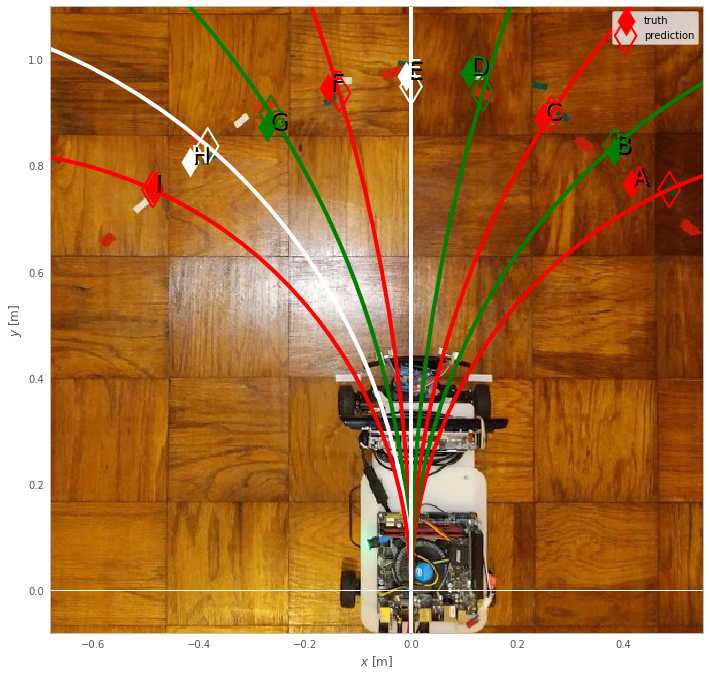

In [5]:
def show_results(label_points=False, draw_arcs=False, label_with_pair_indices=True):
    fig, ax = plt.subplots(figsize=(12,12))
    
    ax.axvline(0, color='w')
    ax.axhline(0, color='w')
    
    ax.imshow(
        cropped,
        origin='lower',
        extent=[-.76-xoffset, .79-xoffset, -.25-yoffset, 1.3-yoffset]
    )
    
    def add_text(x, y, label):
        ax.text(x+offset, y-offset, label, color='black', fontsize=size)
        ax.text(x, y, label, color=c, fontsize=size)

    def draw_arc(reciprocal_diameter, begin, end, label, driving_distance=.98, legend=False, **kw):
        from matplotlib import patches

        xpred, ypred = get_prediction(reciprocal_diameter, best_driving_distance)

        x0, y0 = begin
        x1, y1 = end

        kw.setdefault('linestyle', '-')
        ax.scatter(
            [x1], [y1], color=kw['color'], s=420, marker='d',
            label='truth' if legend else None)
        
        add_text(x1, y1, label)

        ax.scatter(
            [xpred], [ypred], 
            s=650, edgecolor=c, 
            facecolor='none', marker='d', linewidth=2,
            label='prediction' if legend else None
        )

        if reciprocal_diameter == 0:
            ax.axvline(0, **kw)
            return xpred, ypred

        else:
            diameter = 1. / reciprocal_diameter

        xc = diameter / 2.
        yc = 0
        
        #theta = np.abs(360.*driving_distance/np.pi*reciprocal_diameter)
        ax.add_patch(
            patches.Arc(
                [xc,yc], 
                diameter, diameter, angle=0.0, 
                #theta1=0 if reciprocal_diameter<0 else (180 - theta),
                #theta2=theta if reciprocal_diameter<0 else 180.,
                **kw
            )
        )

        return xpred, ypred

    offset = .005
    size = 24
       
    paired = []
    for (i,j,c,w) in pairs:
        paired.append(i)
        paired.append(j)
    
    if not label_with_pair_indices:
        for i in range(len(labeled)):
            if i not in paired:
                add_text(labeled[i, 0], labeled[i, 1], str(i))

    for k, (i, j, c, w) in enumerate(pairs):
        label = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[k]

        reciprocal_radius = w / best_turn_rate

        if label_points:
            for l in (i,j):
                ax.scatter(
                    labeled[l, 0], labeled[l, 1], 
                    edgecolor=c, facecolor='none', s=800, linewidth=2,
                    label=None if l else 'Final front tire positions'
                )
                if not label_with_pair_indices:
                    label = str(l)
                add_text(labeled[l, 0], labeled[l, 1], label)

        if draw_arcs:
            draw_arc(
                reciprocal_radius, labeled[[18,19]].mean(0), labeled[[i,j]].mean(0),
                label,
                color=c, linewidth=4, legend=not k,
            )
            
    ax.legend()

    ax.grid(False)
    ax.set_xlabel('$x$ [m]')
    ax.set_ylabel('$y$ [m]');

    ax.set_xlim(-.68, .55)
    ax.set_ylim(-.08, 1.1);
    
    return fig, ax

show_results(label_points=True, label_with_pair_indices=False)[0].savefig('steering_data_indexed.png')
show_results(label_points=True)[0].savefig('steering_pairs.png')
show_results(draw_arcs=True)[0].savefig('steering_arcs_optimal.png')

Make a gif *(pronounced "yeeve")*.

In [6]:
!convert -delay 200 -loop 0 steering_data_indexed.png steering_pairs.png steering_arcs_optimal.png steering.gif